In [98]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [99]:
#Make a binary classification dataset with Scikit-Learn's make_moons() function.
#For consistency, the dataset should have 1000 samples and a random_state=42.
#Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values


# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [100]:
# Make DataFrame of circle data
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1.0
1,0.954574,-0.473756,1.0
2,0.918526,-0.425196,1.0
3,0.412768,-0.376385,1.0
4,-0.845320,0.528799,0.0
5,0.579542,-0.352979,1.0
6,0.294884,-0.209238,1.0
7,-0.014488,0.435896,1.0
8,1.626510,-0.281207,1.0
9,0.671598,0.786422,0.0


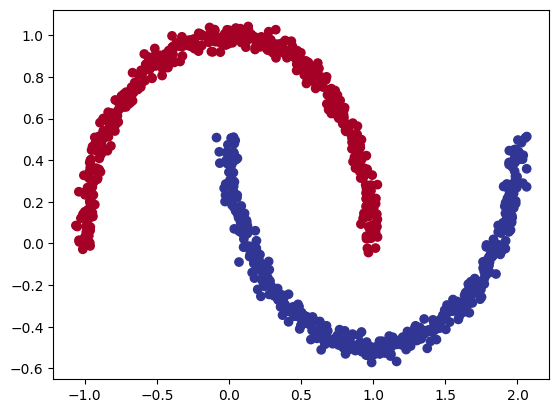

In [101]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [102]:
# Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
# Feel free to use any combination of PyTorch layers (linear and non-linear) you want.


class BinaryClassification(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=20)
    self.layer_2 = nn.Linear(in_features=20, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.leakyrelu = nn.LeakyReLU(0.1)
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(p=0.2)
  def forward(self, x):
    x = self.layer_1(x)
    x = self.dropout(x)
    x = self.leakyrelu(x)
    x = self.layer_2(x)
    x = self.dropout(x)
    x = self.leakyrelu(x)
    x = self.layer_3(x)
    x = self.dropout(x)
    x = self.sigmoid(x)
    return x



In [103]:
model_0 = BinaryClassification().to(device)
model_0

BinaryClassification(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [104]:
# Setup a binary classification compatible loss function and optimizer to use when training the model.

# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
# optimizer = torch.optim.SGD(params=model_0.parameters(),
                            # lr=0.1)

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # Reduce LR by factor of 0.9 every 100 epochs


In [105]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [106]:
# Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
# To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
# Train the model for long enough for it to reach over 96% accuracy.
# The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.


torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    scheduler.step()
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72213, Accuracy: 50.00% | Test loss: 0.71868, Test acc: 50.00%
Epoch: 100 | Loss: 0.58738, Accuracy: 51.50% | Test loss: 0.55131, Test acc: 50.00%
Epoch: 200 | Loss: 0.56484, Accuracy: 58.38% | Test loss: 0.51241, Test acc: 50.00%
Epoch: 300 | Loss: 0.55231, Accuracy: 61.25% | Test loss: 0.50521, Test acc: 60.00%
Epoch: 400 | Loss: 0.54649, Accuracy: 64.38% | Test loss: 0.50402, Test acc: 64.00%
Epoch: 500 | Loss: 0.55538, Accuracy: 63.25% | Test loss: 0.50397, Test acc: 64.00%
Epoch: 600 | Loss: 0.55184, Accuracy: 64.62% | Test loss: 0.50370, Test acc: 64.50%
Epoch: 700 | Loss: 0.55379, Accuracy: 63.62% | Test loss: 0.50351, Test acc: 64.00%
Epoch: 800 | Loss: 0.54563, Accuracy: 64.12% | Test loss: 0.50366, Test acc: 65.50%
Epoch: 900 | Loss: 0.55506, Accuracy: 64.62% | Test loss: 0.50361, Test acc: 65.50%


In [107]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [108]:
# Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


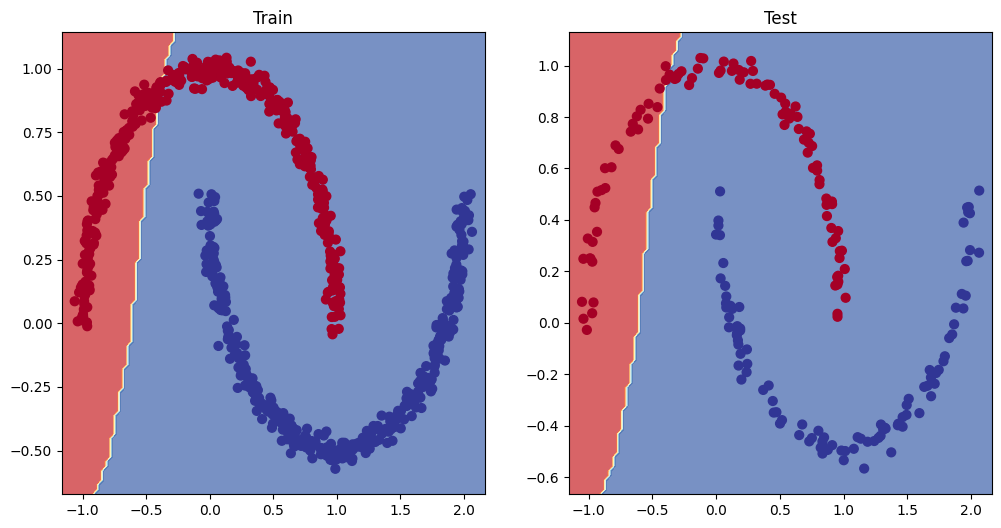

In [109]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [110]:
# Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
# Feel free to reference the ML cheatsheet website for the formula.


In [111]:
# Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
# Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
# Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
# Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
# Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

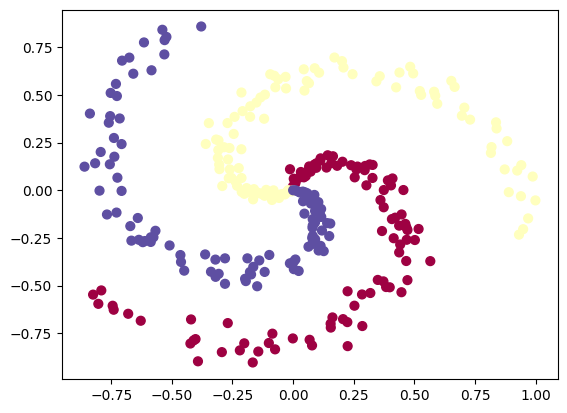

In [112]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()